![](imagegeneratedbyai.png)

Imagine living in a house where every single watt of electricity you use is meticulously recorded, each of which contributes to a vast pool of data. By analyzing this detailed household power consumption data recorded over nearly 4 years, an energy company can help customers achieve sustainable energy usage while balancing their energy generation. With predictive models, the company can optimize energy usage, forecast future consumption, and provide tailored recommendations. Your task is to use this dataset to build a model that predicts power consumption, benefiting both the energy provider and its customers.

## The Data

Available in `df_train.csv` and `df_test.csv`:

| Column             | Type   | Description                                                                 |
|--------------------|--------|----------------------------------------------------------------------------|
| date               | chr    | Date of the measurement                                                    |
| power_consumption  | dbl    | Daily power consumption (in kilowatts)                                     |
| year               | int    | Year of the measurement                                                    |
| semester           | int    | Semester of the measurement (1 for Jan-Jun, 2 for Jul-Dec)                 |
| quarter            | int    | Quarter of the measurement (1 for Q1, 2 for Q2, 3 for Q3, 4 for Q4)        |
| day_in_week        | chr    | Day of the week of the measurement (e.g., Monday, Tuesday)                 |
| week_in_year       | int    | Week number in the year of the measurement                                 |
| day_in_year        | int    | Day number in the year of the measurement                                  |
| month              | int    | Month of the year of the measurement                                       |

This dataset was donated to the UCI Machine Learning Repository. For detailed information about the dataset and the preprocessing steps, please refer to the [License and Data Preprocessing Details](License.ipynb) notebook.

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

# Inspect dataset
print(df_train.info())
print(df_train.head())

# Convert 'date' to datetime and 'day_in_week' to categorical
df_train['date'] = pd.to_datetime(df_train['date'], format="%m/%d/%Y")
df_test['date'] = pd.to_datetime(df_test['date'], format="%m/%d/%Y")

df_train['day_in_week'] = df_train['day_in_week'].astype('category')
df_test['day_in_week'] = df_test['day_in_week'].astype('category')

# One-hot encode 'day_in_week'
df_onehot_train = pd.get_dummies(df_train['day_in_week'], prefix='day_in_week')
df_onehot_test = pd.get_dummies(df_test['day_in_week'], prefix='day_in_week')

# Combine one-hot encoded columns and drop original 'day_in_week'
df_train = pd.concat([df_train.drop(columns='day_in_week'), df_onehot_train], axis=1)
df_test = pd.concat([df_test.drop(columns='day_in_week'), df_onehot_test], axis=1)

# Separate features and target
train_x = df_train.drop(columns=['power_consumption', 'date'])
train_y = df_train['power_consumption']
test_x = df_test.drop(columns=['power_consumption', 'date'])
test_y = df_test['power_consumption']

# ---- Linear Regression ----
lm_model = LinearRegression()
lm_model.fit(train_x, train_y)
lm_pred = lm_model.predict(test_x)
lm_rmse = np.sqrt(mean_squared_error(test_y, lm_pred))

# ---- Random Forest ----
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(train_x, train_y)
rf_pred = rf_model.predict(test_x)
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_pred))

# ---- XGBoost ----
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=1,
    objective='reg:squarederror',
    verbosity=0,
    random_state=42
)
xgb_model.fit(train_x, train_y)
xgb_pred = xgb_model.predict(test_x)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_pred))

# RMSE scores
rmse_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lm_rmse, rf_rmse, xgb_rmse]
})
print(rmse_df)

# Select lowest RMSE
selected_rmse = rmse_df['RMSE'].min()
print("selected_rmse:", selected_rmse, "kW")

# Add predictions to test dataset for plotting
df_test['Predicted'] = rf_pred

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1202 non-null   object 
 1   power_consumption  1202 non-null   float64
 2   year               1202 non-null   int64  
 3   semester           1202 non-null   int64  
 4   quarter            1202 non-null   int64  
 5   day_in_week        1202 non-null   object 
 6   week_in_year       1202 non-null   int64  
 7   day_in_year        1202 non-null   int64  
 8   month              1202 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 84.6+ KB
None
         date  power_consumption  year  semester  quarter day_in_week  \
0  12/16/2006           1209.176  2006         2        4         Sat   
1  12/17/2006           3390.460  2006         2        4         Sun   
2  12/18/2006           2203.826  2006         2        4         Mon   
3  12/

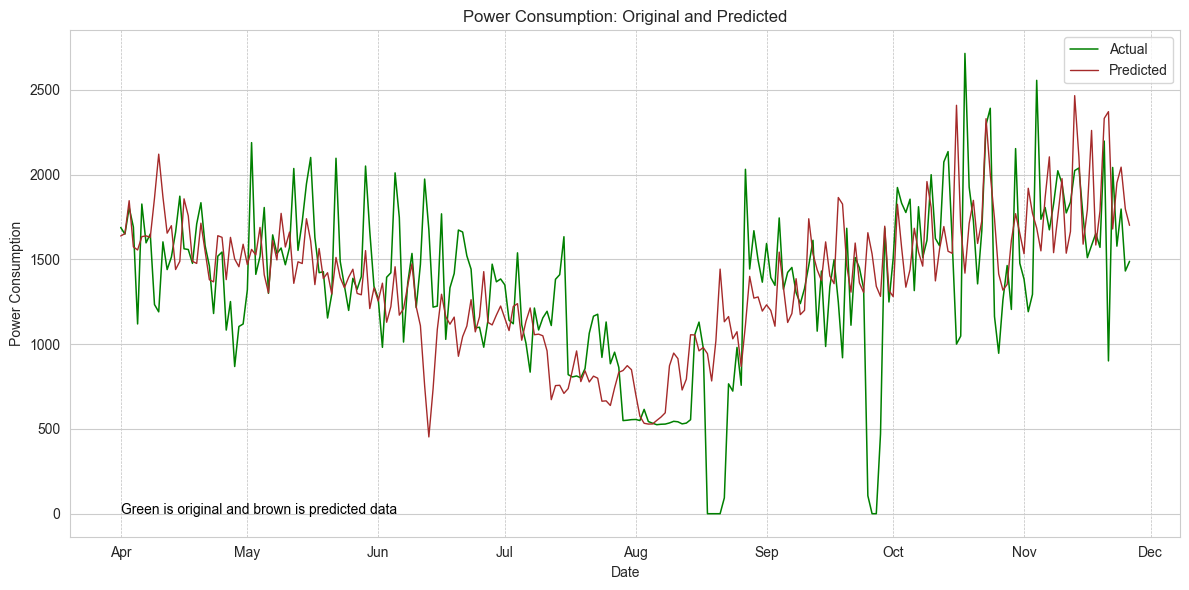

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is datetime
df_test['date'] = pd.to_datetime(df_test['date'])

# Set seaborn style similar to ggplot2 minimal
sns.set_style("whitegrid")

plt.figure(figsize=(12,6))

# Plot actual power consumption
plt.plot(df_test['date'], df_test['power_consumption'], color='green', linewidth=1.1, label='Actual')

# Plot predicted power consumption
plt.plot(df_test['date'], df_test['Predicted'], color='brown', linewidth=1, label='Predicted')

# Title and axis labels
plt.title("Power Consumption: Original and Predicted")
plt.xlabel("Date")
plt.ylabel("Power Consumption")

# Format x-axis with month abbreviations like R's scale_x_date
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Caption (using plt.text in bottom right)
plt.text(df_test['date'].min(), df_test['power_consumption'].min()*0.5,
         "Green is original and brown is predicted data",
         fontsize=10, color='black')

# Minimal grid (only vertical lines like ggplot's panel.grid.major.x)
plt.grid(axis='x', color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

# Rotate x-axis labels if needed
plt.xticks(rotation=0)

plt.legend()
plt.tight_layout()
plt.show()
